# Fine-tune Enformer to perform binary classification on human snATAC-seq data

In this tutorial, we learn how to fine-tune the Enformer model (https://www.nature.com/articles/s41592-021-01252-x) on the CATLAS single-nucleus ATAC-seq dataset from human tissues (http://catlas.org/humanenhancer/). 

We will perform binary classification, in which the model learns to predict the probability that a given sequence is accessible in the different cell types of the dataset. For an example of regression modeling, see the next tutorial.

In [1]:
import anndata
import os
import importlib
import pandas as pd
import numpy as np

%matplotlib inline

## Set experiment parameters

In [2]:
experiment='tutorial_2'
if not os.path.exists(experiment):
    os.makedirs(experiment)

## Load data

We download the CATlas ATAC-seq binary cell type x peak matrix from http://catlas.org/catlas_downloads/humantissues/cCRE_by_cell_type/. Uncomment the code to run.

In [3]:
#!wget http://catlas.org/catlas_downloads/humantissues/cCRE_by_cell_type/matrix.tsv.gz

Now, we load the peak matrix as an AnnData object.

In [4]:
ad = anndata.read_mtx('matrix.tsv.gz').T

# Prepare ad.obs
ad.obs = pd.read_table('http://catlas.org/catlas_downloads/humantissues/cCRE_by_cell_type/celltypes.txt.gz', header=None, names=['cell type'])
ad.obs_names = ad.obs['cell type']

# Prepare ad.var
var = pd.read_table('http://catlas.org/catlas_downloads/humantissues/cCRE_hg38.tsv.gz')
var.columns = ['chrom', 'start', 'end', 'cre_class', 'in_fetal', 'in_adult', 'cre_module']
var.index = var.index.astype(str)
ad.var = var

print(ad.shape)

/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)


(222, 1154611)


This contains a binary matrix representing the accessibility of 1154611 CREs measured in 222 cell types. Let us look at the components of this object:

In [5]:
ad.var.head()

,chrom,start,end,cre_class,in_fetal,in_adult,cre_module
0,chr1,9955,10355,Promoter Proximal,yes,yes,146
1,chr1,29163,29563,Promoter,yes,yes,37
2,chr1,79215,79615,Distal,no,yes,75
3,chr1,102755,103155,Distal,no,yes,51
4,chr1,115530,115930,Distal,yes,no,36


In [6]:
ad.obs.head()

,cell type
cell type,
Follicular,Follicular
Fibro General,Fibro General
Acinar,Acinar
T Lymphocyte 1 (CD8+),T Lymphocyte 1 (CD8+)
T lymphocyte 2 (CD4+),T lymphocyte 2 (CD4+)


The contents of this anndata object are binary values (0 or 1). 1 indicates accessibility of the peak in the cell type.

In [7]:
ad.X[:5, :5].todense()

matrix([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], dtype=float32)

## Filter peaks

We will perform filtering of this dataset using the `grelu.data.preprocess` module.

First, we filter peaks within autosomes (chromosomes 1-22) or chromsomes X/Y. You can also supply `autosomes` or `autosomesX` to further restrict the chromosomes.

In [8]:
import grelu.data.preprocess

ad = grelu.data.preprocess.filter_chromosomes(ad, 'autosomesXY')

Keeping 1154464 intervals


Next, we drop peaks overlapping with the ENCODE blacklist regions for the hg38 genome.

In [9]:
ad = grelu.data.preprocess.filter_blacklist(ad, genome='hg38')

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Keeping 1154464 intervals


## Visualize data

Next, we can plot the distribution of the data in various ways.

In [10]:
import grelu.visualize
%matplotlib inline

In how many accessible cell types is each peak accessible?

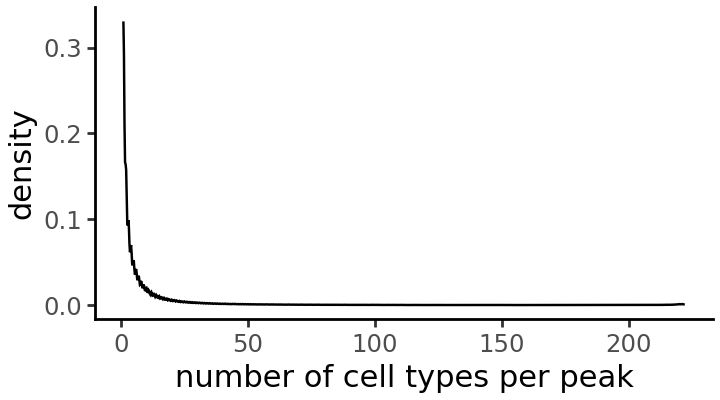

In [11]:
cell_types_per_peak = np.array(np.sum(ad.X > 0, axis=0))

grelu.visualize.plot_distribution(
    cell_types_per_peak,
    title='number of cell types per peak',
    method='density', # Alternative: histogram
    figsize=(3.6, 2), # width, height
)

How many peaks are accessible in each cell type?

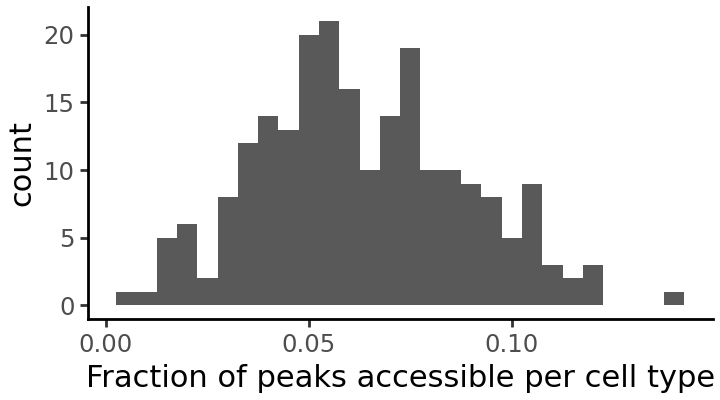

In [12]:
fraction_accessible_per_cell_type = np.array(np.mean(ad.X > 0, axis=1))

grelu.visualize.plot_distribution(
    fraction_accessible_per_cell_type,
    title='Fraction of peaks accessible per cell type',
    method='histogram', # alternative: density
    binwidth=0.005,
    figsize=(3.6, 2), # width, height
)

It seems that some cell types have very few accessible peaks. We will drop these cell types from the dataset.

In [13]:
print(ad.shape)
ad = ad[ad.X.mean(axis=1) > .03, :]
print(ad.shape)

(222, 1154464)
(203, 1154464)


We can plot the distribution once again to see the effect of this filtering:

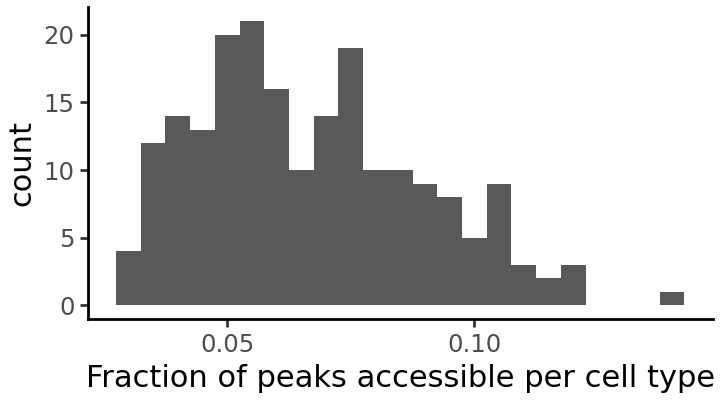

In [14]:
fraction_accessible_per_cell_type = np.array(np.mean(ad.X > 0, axis=1))

grelu.visualize.plot_distribution(
    fraction_accessible_per_cell_type,
    title='Fraction of peaks accessible per cell type',
    method='histogram', # alternative: density
    binwidth=0.005,
    figsize=(3.6, 2), # width, height
)

## Resize peaks

Finally, since the ATAC-seq peaks can have different lengths, we resize all of them to a constant length in order to train the model. Here, we take 200 bp. We can use the `resize` function in `grelu.sequence.utils`, which contains functions to manipulate DNA sequences.

In [15]:
import grelu.sequence.utils
seq_len = 200

ad.var = grelu.sequence.utils.resize(ad.var, seq_len)
ad.var.head(3)

,chrom,start,end,cre_class,in_fetal,in_adult,cre_module
0,chr1,10055,10255,Promoter Proximal,yes,yes,146
1,chr1,29263,29463,Promoter,yes,yes,37
2,chr1,79315,79515,Distal,no,yes,75


## Split data

We will split the peaks by chromosome to create separate sets for training, validation and testing.

In [16]:
train_chroms='autosomes'
val_chroms=['chr10']
test_chroms=['chr11']

ad_train, ad_val, ad_test = grelu.data.preprocess.split(
    ad,
    train_chroms=train_chroms, val_chroms=val_chroms, test_chroms=test_chroms,
)

Selecting training samples
Keeping 1007912 intervals


Selecting validation samples
Keeping 56974 intervals


Selecting test samples
Keeping 56433 intervals
Final sizes: train: (203, 1007912), val: (203, 56974), test: (203, 56433)


## Make labeled sequence datasets

`grelu.data.dataset` contains PyTorch Dataset classes that can load and process genomic data for training a deep learning model. Here, we use the `AnnDataSeqDataset` class which loads data from an AnnData object. Other available dataset classes include `DFSeqDataset` and `BigWigSeqDataset`.

We first make the training dataset. To increase model robustness we use several forms of data augmentation here: `rc=True` (reverse complementing the input sequence), and `max_seq_shift=1` (shifting the coordinates of the input sequence by upto 1 bp in either direction; also known as jitter). We use `augmentation_mode="random"` which means that at each iteration, the model sees a randomly selected augmented version for each sequence.

In [17]:
import grelu.data.dataset

In [18]:
train_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_train.copy(),
    genome='hg38',
    rc=True, # reverse complement
    max_seq_shift=1, # Shift the sequence
    augment_mode="random", # Randomly select which augmentations to apply
)

We do not apply any augmentations to the validation and test datasets (although it is possible to do so).

In [19]:
val_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_val.copy(), genome='hg38')
test_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_test.copy(), genome='hg38')

## Build the enformer model

gReLU contains many model architectures. One of these is a class called `EnformerPretrainedModel`. This class creates a model identical to the published Enformer model and initialized with the trained weights, but where you can change the number of transformer layers and the output head.

Models are created using the `grelu.lightning` module. In order to instantiate a model, we need to specify a dictionary `model_params` which contains parameters for the model architecture.

In [28]:
model_params = {
    'model_type':'EnformerPretrainedModel', # Type of model
    'n_tasks': ad.shape[0], # Number of cell types to predict
    'crop_len':0, # No cropping of the model output
    'n_transformers': 1, # Number of transformer layers; the published Enformer model has 11
}

import grelu.lightning
import importlib
importlib.reload(grelu.lightning)
model = grelu.lightning.LightningModel(model_params=model_params)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


## Train the model

We train the model on the new training dataset using the `train_on_dataset` method. Note that here, we update the weights of the entire model during training. If you want to hold the enformer weights fixed and only learn a linear layer from the enformer embedding to the outputs, see the `tune_on_dataset` method.

In [29]:
# See the 'tutorial_2' folder for logs
trainer = model.train_on_dataset(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    
    task='binary', # binary classification
    logger='csv', # Logs will be written to a CSV file
    save_dir=experiment, # Directory where checkpoints will be saved

    optimizer='adam',
    lr=1e-4, # learning rate
    batch_size=1024,
    num_workers=16,
    devices=0, # GPU index
    max_epochs=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  9.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.4909706711769104     │
│         val_auroc         │    0.49353140592575073    │
│        val_avgprec        │    0.10445020347833633    │
│        val_best_f1        │    0.16722486913204193    │
│         val_loss          │    0.6943224668502808     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type                    | Params | Mode 
-----------------------------------------------------------------
0 | model        | EnformerPretrainedModel | 72.1 M | train
1 | transform    | Identity                | 0      | train
2 | loss         | BCEWithLogitsLoss       | 0      | train
3 | val_metrics  | MetricCollection        | 0      | train
4 | test_metrics | MetricCollection        | 0      | train
-----------------------------------------------------------------
72.1 M    Trainable params
0         Non-trainable params
72.1 M    Total params
288.267   Total estimated model params size (MB)
240       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 985/985 [03:12<00:00,  5.12it/s, v_num=0, train_loss_step=0.145]
Validation: |                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 985/985 [03:14<00:00,  5.07it/s, v_num=0, train_loss_step=0.138, train_loss_epoch=0.171]
Validation: |                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████


Detected KeyboardInterrupt, attempting graceful shutdown ...


Validation DataLoader 0:   0%|                                                                                                                                                                                      | 0/56 [15:21<?, ?it/s]


NameError: name 'exit' is not defined

## Load best model from checkpoint

During training, the performance of the model on the validation set is checked after each epoch. We will load the version of the model that had the best validation set performance.

In [37]:
#best_checkpoint = trainer.checkpoint_callback.best_model_path
best_checkpoint = 'tutorial_2/2025_14_02_19_02/version_0/checkpoints/epoch=3-step=3940.ckpt'
print(best_checkpoint)

#import importlib
#importlib.reload(grelu.lightning)
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

tutorial_2/2025_14_02_19_02/version_0/checkpoints/epoch=3-step=3940.ckpt


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


In [38]:
model.train_params

{'checkpoint_path': None,
 'task': 'binary',
 'lr': 0.0001,
 'optimizer': 'adam',
 'batch_size': 1024,
 'num_workers': 16,
 'devices': 0,
 'logger': 'csv',
 'save_dir': 'tutorial_2',
 'max_epochs': 10,
 'callbacks': None,
 'loss': 'bce',
 'clip': 0,
 'pos_weight': None,
 'class_weights': None,
 'total_weight': None,
 'name': '2025_14_02_19_02'}

## Calculate performance metrics on the test set

We calculate global performance metrics using the `test_on_dataset` method.

In [40]:
test_metrics = model.test_on_dataset(
    test_dataset,
    devices=0,
    num_workers=16,
    batch_size=1024,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  9.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9457458853721619     │
│        test_auroc         │    0.9032458662986755     │
│       test_avgprec        │     0.604186475276947     │
│       test_best_f1        │    0.5658239126205444     │
│         test_loss         │    0.1554810106754303     │
└───────────────────────────┴───────────────────────────┘

`test_metrics` is a dataframe containing metrics for each model task.

In [41]:
test_metrics.head()

,test_accuracy,test_auroc,test_avgprec,test_best_f1
Follicular,0.907696,0.875304,0.619861,0.571016
Fibro General,0.916379,0.880690,0.623466,0.575376
Acinar,0.944058,0.911765,0.648223,0.599197
T Lymphocyte 1 (CD8+),0.961140,0.930071,0.631303,0.593218
T lymphocyte 2 (CD4+),0.966828,0.938996,0.616377,0.570145


## Visualize performance metrics

We can plot the distribution of each metric across all cell types:

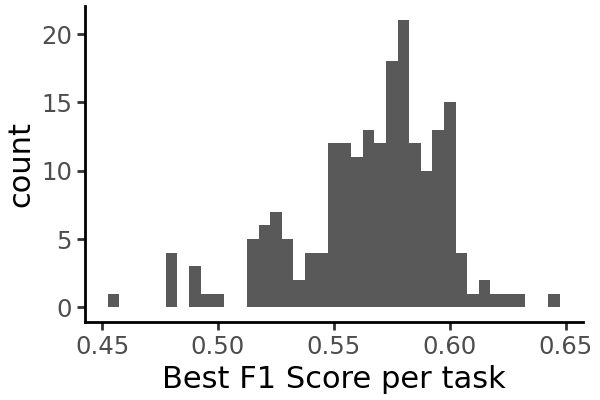

In [42]:
grelu.visualize.plot_distribution(
    test_metrics.test_best_f1,
    method='histogram',
    title='Best F1 Score per task',
    binwidth=0.005,
    figsize=(3,2),
)

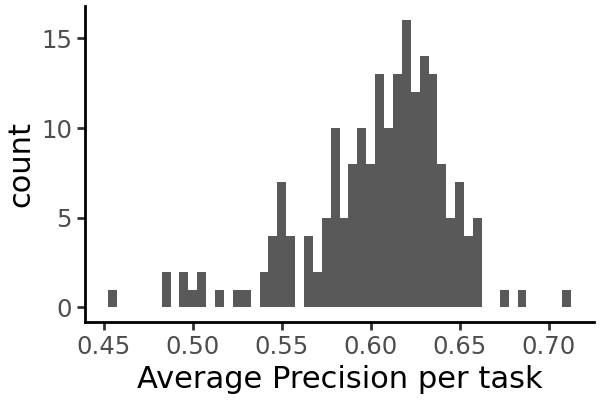

In [43]:
grelu.visualize.plot_distribution(
    test_metrics.test_avgprec,
    method='histogram',
    title='Average Precision per task',
    binwidth=0.005,
    figsize=(3,2),
)

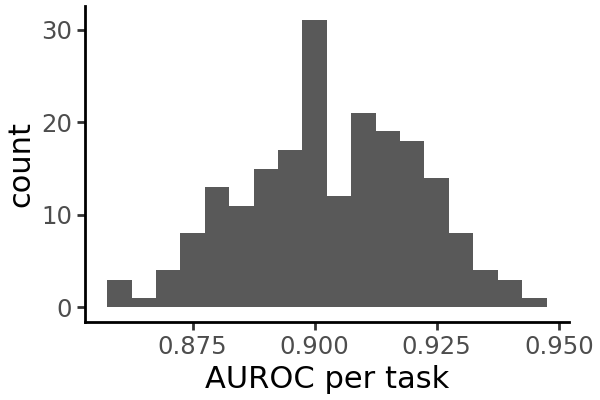

In [44]:
grelu.visualize.plot_distribution(
    test_metrics.test_auroc,
    method='histogram',
    title='AUROC per task',
    binwidth=0.005,
    figsize=(3,2),
)

## Run inference on the test set

Instead of overall metrics, we can also get the individual predictions for each test set example.

In [45]:
probs = model.predict_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=1024,
    return_df=True # Return the output as a pandas dataframe
)

probs.head()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 14.36it/s]


,Follicular,Fibro General,Acinar,T Lymphocyte 1 (CD8+),T lymphocyte 2 (CD4+),Natural Killer T,Naive T,Fibro Epithelial,Cardiac Pericyte 1,Pericyte General 1,...,Fetal Cardiac Fibroblast,Fetal Fibro General 2,Fetal Fibro Muscle 1,Fetal Fibro General 3,Fetal Mesangial 2,Fetal Stellate,Fetal Alveolar Epithelial 1,Fetal Cilliated,Fetal Excitatory Neuron 1,Fetal Excitatory Neuron 2
0,0.189482,0.450705,0.355155,0.512261,0.383700,0.292907,0.324355,0.396388,0.254112,0.501045,...,0.186645,0.182221,0.187261,0.230218,0.223016,0.109419,0.230945,0.197136,0.226578,0.160382
1,0.012090,0.036855,0.002525,0.056674,0.070684,0.026302,0.024545,0.006499,0.041183,0.005139,...,0.048810,0.033304,0.020402,0.022241,0.012683,0.019125,0.019900,0.011282,0.036862,0.015755
2,0.020121,0.040138,0.009646,0.065926,0.054036,0.053365,0.023975,0.033611,0.123926,0.023588,...,0.040614,0.018815,0.021260,0.050182,0.029737,0.011643,0.019728,0.019521,0.283341,0.033031
3,0.759503,0.814330,0.893988,0.810377,0.837316,0.732691,0.788252,0.708531,0.747316,0.657758,...,0.803062,0.755318,0.735310,0.811716,0.773993,0.608135,0.874762,0.844497,0.703712,0.479891
4,0.349553,0.548380,0.564760,0.681297,0.624840,0.549857,0.450568,0.501038,0.322402,0.209156,...,0.370941,0.397122,0.299988,0.602701,0.332766,0.235776,0.647898,0.638033,0.304818,0.177954


Since this is a binary classification model, the output takes the form of probabilities ranging from 0 to 1. We interpret these as the predicted probabilities of the element being accessible in each cell type.

## Plot additional visualizations of the test set predictions

We can plot a calibration curve for all the tasks. This shows us the fraction of true positive examples, for different levels of model-predicted probability. 

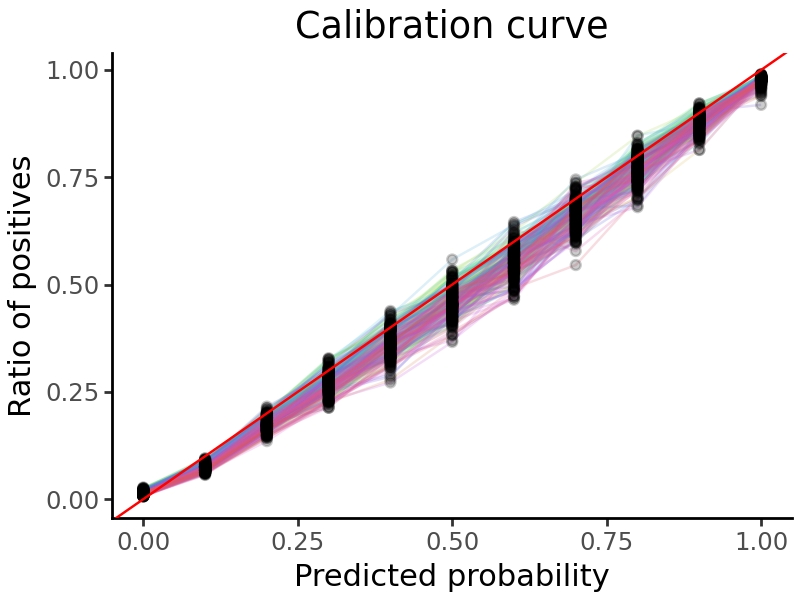

In [46]:
grelu.visualize.plot_calibration_curve(
    probs, labels=test_dataset.labels, aggregate=False, show_legend=False
)

We can also pick any cell type and compare the predictions on accessible and non-accessible elements.

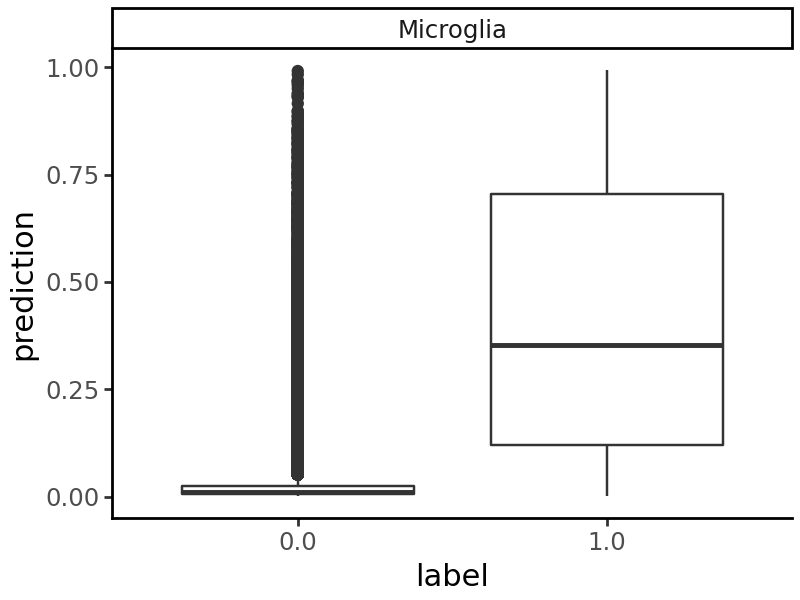

In [47]:
grelu.visualize.plot_binary_preds(
    probs,
    labels=test_dataset.labels,
    tasks='Microglia',
    figure_size=(3, 2) # Width, height
)

## Interpret model predictions (for microglia) using TF-modisco

Suppose we want to focus specifically on Microglia. We can create a transform - a class that takes in the model's prediction and returns a function of the prediction, e.g. the prediction for only a subset of cell types that we are interested in. Then, all subsquent analyses that we do will be based only on this subset of the full prediction matrix.

Here, we use the `Aggregate` class to create a transform that will take in the full set of predictions produced by the model and subset only the predictions in Microglia.

In [30]:
from grelu.transforms.prediction_transforms import Aggregate

microglia_score = Aggregate(
    tasks = ["Microglia"],
    model = model,
)

Let us now identify all peaks in the test set that are accessible in microglia.

In [31]:
is_accessible_in_mcg = np.array(ad_test["Microglia", :].X.todense()==1).squeeze()
mcg_peaks = ad_test.var[is_accessible_in_mcg]
len(mcg_peaks)

2273

We now run TF-Modisco on these peaks. TF-modisco identifies motifs that consistently contribute to the model's output. Since we are using the `microglia_score` filter to limit the model's prediction to microglia, we will only get motifs relevant to this cell type. We also use TOMTOM to match the TF-Modisco motifs to a set of reference motifs. Here, we use a reference set of non-redundant motifs (https://www.vierstra.org/resources/motif_clustering) that are provided with gReLU as `consensus`.

In [33]:
%%time
import grelu.interpret.modisco
grelu.interpret.modisco.run_modisco(
    model,
    seqs=mcg_peaks, 
    genome="hg38",
    prediction_transform=microglia_score, # Base importance scores will be calculated with respect to this output
    meme_file="hocomoco_v12", # We will compare the Modisco CWMs to HOCOMOCO motifs
    method="ism", # Base-level attribution scores will be calculated using ISM. You can also use "saliency".
    out_dir=experiment,
    batch_size=1024,
    devices=0,
    num_workers=16,
    window=100, # ISM scores will be calculated over the central 100 bp of each peak
    seed=0,
)

Performing ISM


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.16it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 666/666 [00:47<00:00, 14.13it/s]
Running modisco
Testing DataLoader 0:   0%|                                                                                                                                                                                         | 0/56 [02:24<?, ?it/s]


/opt/conda/lib/python3.11/site-packages/modiscolite/tfmodisco.py:128: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


Writing modisco output
Creating sequence logos
Creating html report
Running TOMTOM
CPU times: user 3h 25min 17s, sys: 1min 21s, total: 3h 26min 39s
Wall time: 9min 9s


## Load TOMTOM output for modisco motifs

The full output of TF-Modisco and TOMTOM can be found in the experiment folder. Here, we read the output of TOMTOM and list the significant TOMTOM matches, i.e. known TF motifs that are similar to those found by TF-MoDISco.

In [36]:
tomtom_file = os.path.join(experiment, 'tomtom.csv')
tomtom = pd.read_csv(tomtom_file, index_col=0)

tomtom[tomtom['q-value'] < 1e-4] # Display most significant matches

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
950,pos_pattern_0,SPI1.H12CORE.0.P.B,2.0,1.938174e-08,2.796785e-05,3.729047e-05,7.0,ACTTCCT,AAAAGAGGAAGTGA,-
1861,pos_pattern_1,IRF4.H12CORE.0.P.B,2.0,8.912515e-11,1.286076e-07,5.144304e-07,14.0,TTTCACTTCCTCTT,AAAGAGGAACTGAAACT,-
1870,pos_pattern_1,IRF8.H12CORE.0.P.B,5.0,3.314362e-10,4.782625e-07,9.565249e-07,14.0,TTTCACTTCCTCTT,AAGAGGAAGTGAAAGTAAA,-
2395,pos_pattern_1,SPIB.H12CORE.0.P.B,1.0,3.247408e-08,4.686009e-05,3.748807e-05,14.0,TTTCACTTCCTCTT,AAAGAGGAAGTGAAAG,-
2995,pos_pattern_2,CTCFL.H12CORE.0.P.B,-1.0,5.496209e-08,7.931030e-05,5.287353e-05,15.0,CGCCGCCCCCTCCTGG,GCCGCCAGGGGGCGCC,-
3822,pos_pattern_2,SP2.H12CORE.1.P.B,5.0,2.985629e-08,4.308262e-05,3.748807e-05,16.0,CGCCGCCCCCTCCTGG,CCGGCGGGGGGCGGGGCCGGG,-
